**El problema**

 Se obtiene una base de datos sobre los resultados de las pruebas "SABER" que los estudiantes de grado 11 de la ciudad de Bogotá presentan en los diferentes colegios de la misma. En la base de datos inicial se encuentra la especificación por asignatura con su respectivo puntaje, así como el promedio de todas las asignaturas, utilizamos este último para establecer si el desempeño de los colegios fue positivo o negativo para luego tener en cuenta la localidad en la que esta ubicada la institución educativa. Resumimos la base de datos en una nueva donde las campos son el código del colegio, Localidad, Puntaje y Pérdida, este último campo hace referencia a la conversión binaria de si el colegio obtuvo más de 250 puntos en promedio, se entiende que tuvo un buen desempeño, por lo tanto, se le asigna el valor cero, en caso contraio se asigna el valor 1 indicando que obtuvo pérdida, pues el máximo puntaje posible es 500.


 El problema consiste en predecir que colegios tendrán perdida en el futuro según el condicionamiento de localidad. Se usará análisis de regresión con el fin de capturar la relación entre características y desempeño en las pruebas.





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Carga de Datos

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving BBDD2 - Hoja 1.csv to BBDD2 - Hoja 1.csv
User uploaded file "BBDD2 - Hoja 1.csv" with length 14495 bytes


En el fichero CSV, como se ha mencionado, están incluidas la variable localidad y puntaje.

In [ ]:
import pandas as pd
import io
COLEGIOS = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')),  index_col = 'OBJECTID')
COLEGIOS.head()

,LOCALIDAD,P_Puntaje_,PERDIDA
OBJECTID,,,
1,17,265,0
2,17,245,1
3,17,259,0
4,17,261,0
5,17,241,1


In [ ]:
COLEGIOS.shape

(1079, 3)

Analisis descriptivo de la variable puntaje.

In [ ]:
COLEGIOS[["P_Puntaje_"]].describe()

,P_Puntaje_
count,1079.000000
mean,275.116775
std,30.222847
min,0.000000
25%,255.000000
50%,269.000000
75%,293.000000
max,386.000000


# Exploración

Vamos a explorar con estadística básica nuestro conjunto de datos para ver si podemos sacar alguna conclusión

In [ ]:
#0.2 Explore Data
# charts from https://machinelearningmastery.com/visualize-machine-learning-data-python-pandas/
import matplotlib.pyplot as plt
plt.rcdefaults()

Los histogramas agrupan los datos en ubicaciones  y proporcionan un recuento de los
número de observaciones en cada caso.
Sirven para identificar la distribución de los datos, y es posible que nos permita también identificación valores atípicos.

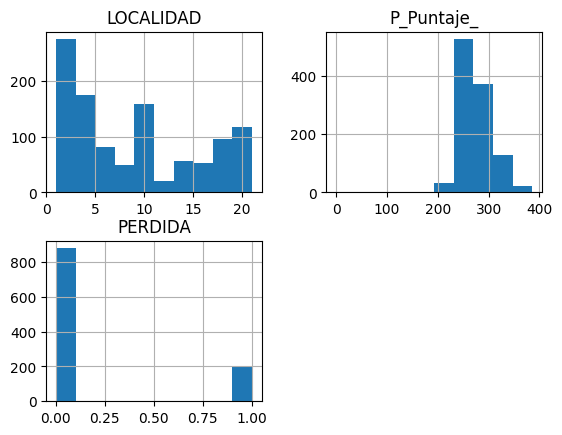

In [ ]:
#0.2.1 Univariate Histograms
#
COLEGIOS.hist()
plt.show()

Los diagramas de densidad son otra forma de tener una idea rápida de la distribución de cada atributo. Los diagrams parecen *histogramas abstractos* que mediante una curva suve dibujan la distribución de los datos.

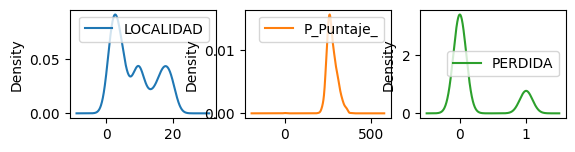

In [ ]:
#0.2.2 Density Plots
COLEGIOS.plot(kind='density', subplots=True, layout=(3,3), sharex=False)
plt.show()


Se observa gran número de colegios ubicados en las primeras localidades, la mayotria de puntajes están concentrados entre los 250 y 300 puntos y por último, es muy pequeño el porcentaje de colegios con bajo desempeño en comparación con su opuesto.

Un gráfico de dispersión (ScatterPlot) muestra la relación entre las localidades y los puntajes como puntos en dos  dimensiones, un eje por cada atributo. En principio, se observa que parece haber una relación uniforme entre estas variables.

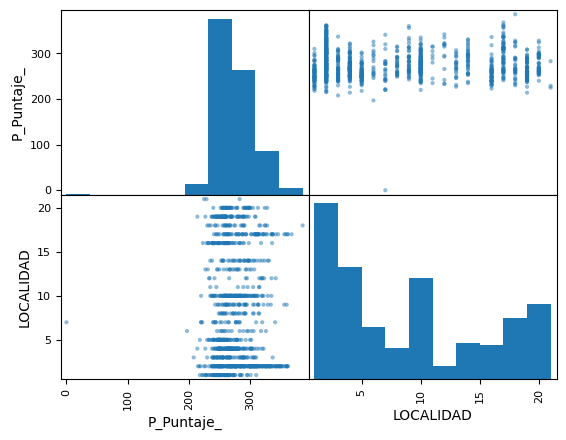

In [ ]:
#0.2.3 Scatterplot matrix
from pandas.plotting import scatter_matrix
scatter_matrix(COLEGIOS[["P_Puntaje_","LOCALIDAD"]])
plt.show()

Los diagramas de correlación nos indicarán cuan correlacionadas están los puntajes y la localidad con el valor a predecir "PERDIDA".

<ipython-input-18-2e0b2d4dee44>:2: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


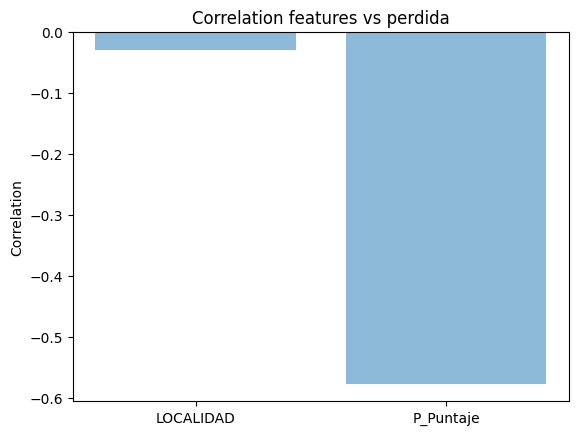

[-0.029571844696514145, -0.5763688604651862]

In [ ]:
import numpy as np
from scipy.stats.stats import pearsonr
corr = [pearsonr(COLEGIOS['LOCALIDAD'], COLEGIOS['PERDIDA'])[0], pearsonr(COLEGIOS['P_Puntaje_'], COLEGIOS['PERDIDA'])[0]]


features= ('LOCALIDAD', 'P_Puntaje')
y_pos = np.arange(len(features))

plt.bar(y_pos, corr, align='center', alpha=0.5)
plt.xticks(y_pos, features)
plt.ylabel('Correlation')
plt.title('Correlation features vs perdida')

plt.show()

corr


# Modelado

Luego de realizar una revisión analítica de los datos, nos disponemos a probar un modelo de regresión para conocer en principio cómo se podría predecir el comportamiento de los puntajes según la localidad.

## Modelo con una sola variable

In [ ]:
#1.1 Parametrización del modelo
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(criterion='poisson', max_depth=10, random_state=0)

In [ ]:
#1.2 Construcción del modelo con localidad como predictor
regressor.fit(COLEGIOS[['LOCALIDAD']], COLEGIOS['P_Puntaje_'])

DecisionTreeRegressor(criterion='poisson', max_depth=10, random_state=0)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


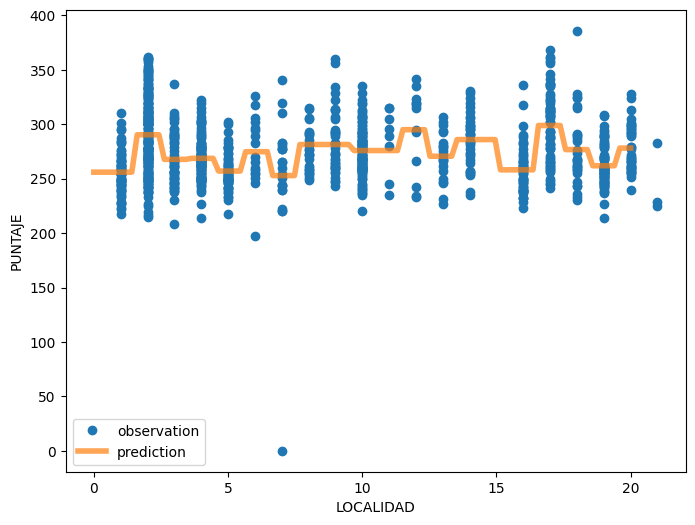

In [ ]:
# 2.2 representación del modelo
xx = np.array([np.linspace(0, 20, 100)]).T

plt.figure(figsize=(8,6))
plt.plot(COLEGIOS['LOCALIDAD'], COLEGIOS['P_Puntaje_'], 'o', label='observation')
plt.plot(xx, regressor.predict(xx), linewidth=4, alpha=.7, label='prediction')
plt.xlabel('LOCALIDAD')
plt.ylabel('PUNTAJE')
plt.legend()
plt.show()

Observamos pues, una predicción en la que la localidad 2, 12 y 17 sobresalen en desempeño ante las demás, sin embargo, no es muy notoria esta propiedad. Intentaremos con un modelo de dos variables.

## Modelo con dos variables

In [ ]:
#1.1 Model Parametrization
# criterion: mse mean squared error, which is equal to variance reduction as feature selection criterion
#splitter: best/random
# max_depth: low value avoid overfitting
regressor = DecisionTreeRegressor(criterion='poisson', max_depth=10, random_state=0)



In [ ]:
#1.2 Model construction
regressor.fit(COLEGIOS[['LOCALIDAD', 'PERDIDA']], COLEGIOS['P_Puntaje_'])

DecisionTreeRegressor(criterion='poisson', max_depth=10, random_state=0)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


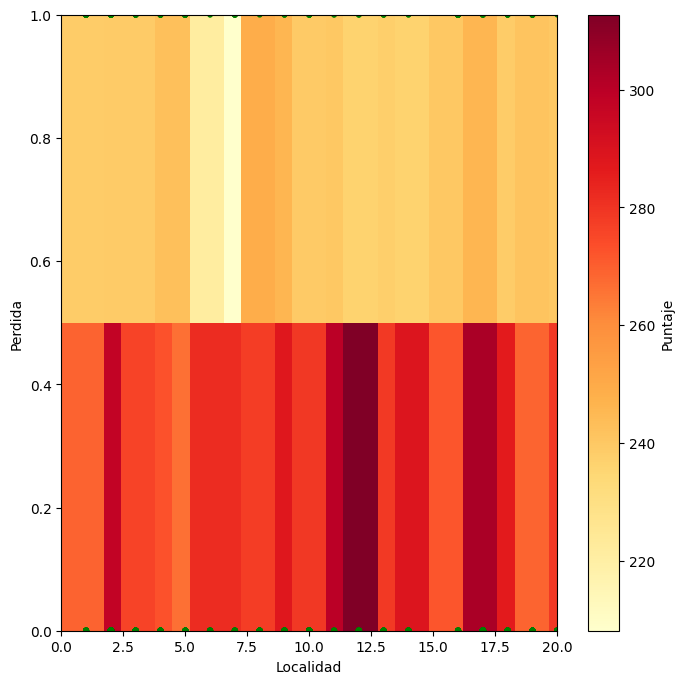

In [ ]:
# This visualization is only useful for a model of two predictors

nx = 30
ny = 30
# creating a grid of points
x_temperature = np.linspace(0, 20, nx)
y_humidity = np.linspace(0, 1, ny)
xx, yy = np.meshgrid(x_temperature, y_humidity)
# evaluating the regresson on all the points
z_bikes = regressor.predict(np.array([xx.flatten(), yy.flatten()]).T)
zz = np.reshape(z_bikes, (nx, ny))


fig = plt.figure(figsize=(8, 8))
# plotting the predictions
plt.pcolormesh(x_temperature, y_humidity, zz, cmap=plt.cm.YlOrRd)
plt.colorbar(label='Puntaje') # add a colorbar on the right
# plotting also the observations
plt.scatter(COLEGIOS['LOCALIDAD'], COLEGIOS['PERDIDA'], s=COLEGIOS['P_Puntaje_']/25.0, c='g')
# setting the limit for each axis
plt.xlim(np.min(x_temperature), np.max(x_temperature))
plt.ylim(np.min(y_humidity), np.max(y_humidity))
plt.xlabel('Localidad')
plt.ylabel('Perdida')
plt.show()


La interpretación que podemos dar en este modelo de dos variables es que, como es de esperar, el puntaje se acerca a 400 a medida que la variable "Perdida" se aproxima a cero, es decir, hubo un buen desempeño. En contraste, si se aproxima a uno, esto es, el conjunto de colegios cuyo desempeño no ha sido positivo, obtenemos que nuestra variable proyector "P_Puntaje_" disminuye hacia 200 aproximadamente, por otro lado, se puede establecer que las localidades 2, 12 y 17 presentan un mejor desempeño, sin embargo, esta relación no es tan fuerte como quisiéramos para concluir alguna influencia entre las localidades y el puntaje obtenido en las pruebas.

**REGRESIÓN LOGISTICA PARA EL PRIMER MODELO**

Estos modelos, son modelos poco robustos, así que haremos uso de un modelo de regresión logistica.

In [ ]:
COLEGIOS[['LOCALIDAD','PERDIDA']].head()

,LOCALIDAD,PERDIDA
OBJECTID,,
1,17,0
2,17,1
3,17,0
4,17,0
5,17,1


<Axes: xlabel='LOCALIDAD', ylabel='PERDIDA'>

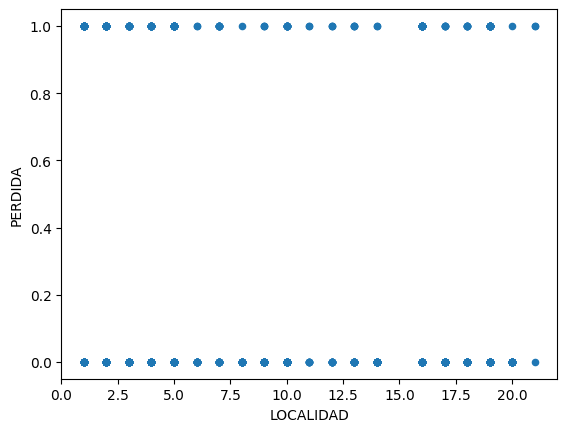

In [ ]:
COLEGIOS[['LOCALIDAD','PERDIDA']].plot.scatter(x='LOCALIDAD',y='PERDIDA')

In [ ]:
# pruebas de parametro
w = 0.5
b = -4.6

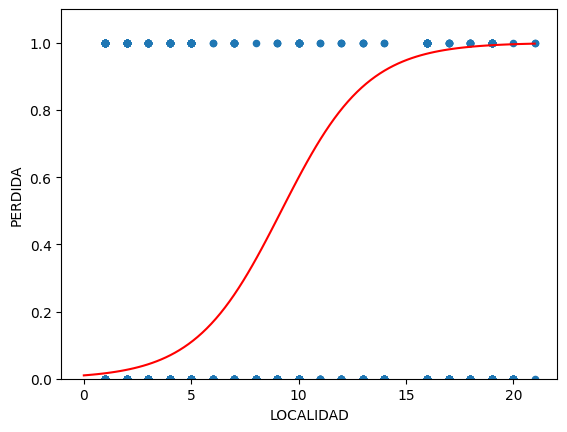

In [ ]:
# puntos de la recta
x = np.linspace(0,COLEGIOS['LOCALIDAD'].max(),100)
y = 1/(1+np.exp(-(w*x+b)))

# grafica de la recta
COLEGIOS.plot.scatter(x='LOCALIDAD',y='PERDIDA')
plt.plot(x, y, '-r')
plt.ylim(0,COLEGIOS['PERDIDA'].max()*1.1)
# plt.grid()
plt.show()

In [ ]:
# calculo de las predicciones
COLEGIOS['sigmoid'] = 1/(1+np.exp(-(COLEGIOS['LOCALIDAD']*w+b)))

# calculo de la funcion de error
COLEGIOS['loss_xi'] = -COLEGIOS['PERDIDA']*np.log(COLEGIOS['sigmoid'])-(1-COLEGIOS['PERDIDA'])*np.log(1-COLEGIOS['sigmoid'])
cost_j = COLEGIOS['loss_xi'].mean()
cost_j

1.4939515234151237

Hacemos dataframe para calcular el error en funcion de los parametros w, b

In [ ]:
array = np.mgrid[0.05:0.15:0.01, -4:-3:0.01].reshape(2,-1).T
df = pd.DataFrame(data = array,
                  columns = ['w','b'])

# round para solventar problema con muchos decimales
df['w'] = np.round(df['w'], 6)
df['b'] = np.round(df['b'], 6)

In [ ]:
df

,w,b
0,0.05,-4.00
1,0.05,-3.99
2,0.05,-3.98
3,0.05,-3.97
4,0.05,-3.96
...,...,...
995,0.14,-3.05
996,0.14,-3.04
997,0.14,-3.03
998,0.14,-3.02


In [ ]:
def sum_error_df(df):
    COLEGIOS['sigmoid'] = 1/(1+np.exp(-(COLEGIOS['LOCALIDAD']*df['w']+df['b'])))
    COLEGIOS['loss_xi'] = -COLEGIOS['PERDIDA']*np.log(COLEGIOS['sigmoid'])-(1-COLEGIOS['PERDIDA'])*np.log(1-COLEGIOS['sigmoid'])
    j_cost = COLEGIOS['loss_xi'].mean()
    return(j_cost)

df['error'] = df.apply(sum_error_df, axis=1)
df.sort_values(by=['error']).head()

,w,b,error
599,0.10,-3.01,0.537294
699,0.11,-3.01,0.537731
598,0.10,-3.02,0.537958
698,0.11,-3.02,0.538273
597,0.10,-3.03,0.538631


In [ ]:
df_3d = df.pivot(index='w', columns='b', values='error')
df_3d.head()

b,-4.00,-3.99,-3.98,-3.97,-3.96,-3.95,-3.94,-3.93,-3.92,-3.91,...,-3.10,-3.09,-3.08,-3.07,-3.06,-3.05,-3.04,-3.03,-3.02,-3.01
w,,,,,,,,,,,,,,,,,,,,,
0.05,0.694940,0.693374,0.691812,0.690252,0.688695,0.687141,0.685590,0.684042,0.682496,0.680954,...,0.569032,0.567855,0.566685,0.565522,0.564364,0.563214,0.562069,0.560932,0.559801,0.558676
0.06,0.683088,0.681554,0.680023,0.678495,0.676971,0.675450,0.673931,0.672416,0.670905,0.669396,...,0.561501,0.560394,0.559294,0.558200,0.557114,0.556034,0.554962,0.553896,0.552838,0.551787
0.07,0.671738,0.670240,0.668745,0.667254,0.665767,0.664283,0.662802,0.661326,0.659852,0.658383,...,0.555047,0.554017,0.552995,0.551980,0.550973,0.549973,0.548981,0.547997,0.547021,0.546052
0.08,0.660969,0.659513,0.658060,0.656611,0.655166,0.653724,0.652287,0.650854,0.649424,0.647999,...,0.549812,0.548869,0.547934,0.547007,0.546088,0.545177,0.544275,0.543381,0.542496,0.541619
0.09,0.650874,0.649465,0.648060,0.646658,0.645262,0.643869,0.642481,0.641097,0.639718,0.638343,...,0.545949,0.545102,0.544264,0.543434,0.542613,0.541801,0.540998,0.540205,0.539420,0.538645


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

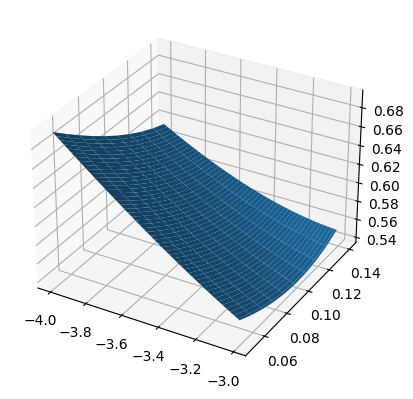

In [ ]:
x = df_3d.columns
y = df_3d.index
X,Y = np.meshgrid(x,y)
Z = df_3d

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

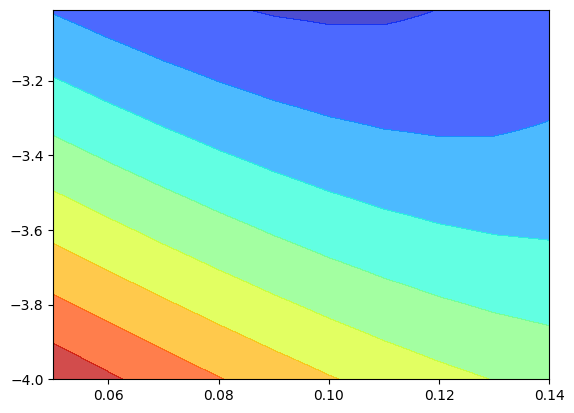

In [ ]:
x = df_3d.columns
y = df_3d.index
X,Y = np.meshgrid(x,y)
Z = df_3d
plt.contourf(Y, X, Z, alpha=0.7, cmap=plt.cm.jet)

OPTIMIZACIÓN DE PARÁMETROS

In [ ]:
def delta_j_w(w, b):
    COLEGIOS['sigmoid'] = 1/(1+np.exp(-(COLEGIOS['LOCALIDAD']*w+b)))
    COLEGIOS['partial_loss'] = (COLEGIOS['sigmoid']-COLEGIOS['PERDIDA'])*COLEGIOS['LOCALIDAD']
    derivative = COLEGIOS['partial_loss'].mean()
    return(derivative)

def delta_j_b(w, b):
    COLEGIOS['sigmoid'] = 1/(1+np.exp(-(COLEGIOS['LOCALIDAD']*w+b)))
    COLEGIOS['partial_loss'] = (COLEGIOS['sigmoid']-COLEGIOS['PERDIDA'])
    derivative = COLEGIOS['partial_loss'].mean()
    return(derivative)

valores iniciales

In [ ]:
w_0 = 0.1
b_0 = -3.01

In [ ]:
alpha_w = 0.001
alpha_b = 0.1

w_new = w_0 - alpha_w * delta_j_w(w_0, b_0)
b_new = b_0 - alpha_b * delta_j_b(w_0, b_0)

w_0 = w_new
b_0 = b_new

print(w_0, b_0)

0.09971297539104154 -2.901374511164657


Ahora vamos a hacer lo mismo pero mucho más rápido con sklear

In [ ]:
from sklearn.linear_model import LogisticRegression

# definiendo input y output
X_train = np.array(COLEGIOS['LOCALIDAD']).reshape((-1, 1))
Y_train = np.array(COLEGIOS['PERDIDA'])

# creando modelo
model = LogisticRegression()
model.fit(X_train, Y_train)

# imprimiendo parametros
print(f"intercepto (b): {model.intercept_}")
print(f"pendiente (w): {model.coef_}")

intercepto (b): [-1.37889017]
pendiente (w): [[-0.01209126]]


In [ ]:
# pruebas de parametro
w = 0.09971297539104154
b = -2.901374511164657

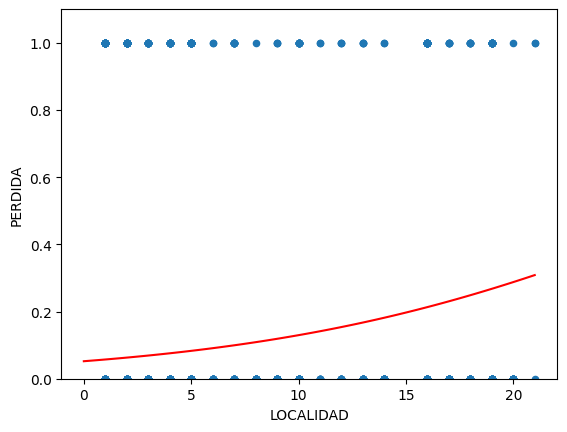

In [ ]:
# puntos de la recta
x = np.linspace(0,COLEGIOS['LOCALIDAD'].max(),100)
y = 1/(1+np.exp(-(w*x+b)))

# grafica de la recta
COLEGIOS.plot.scatter(x='LOCALIDAD',y='PERDIDA')
plt.plot(x, y, '-r')
plt.ylim(0,COLEGIOS['PERDIDA'].max()*1.1)
# plt.grid()
plt.show()

**REGRESIÓN LOGISTICA PARA EL SEGUNDO MODELO**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
X1 = 'LOCALIDAD'
X2 = 'P_Puntaje_'
Y = 'PERDIDA'

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


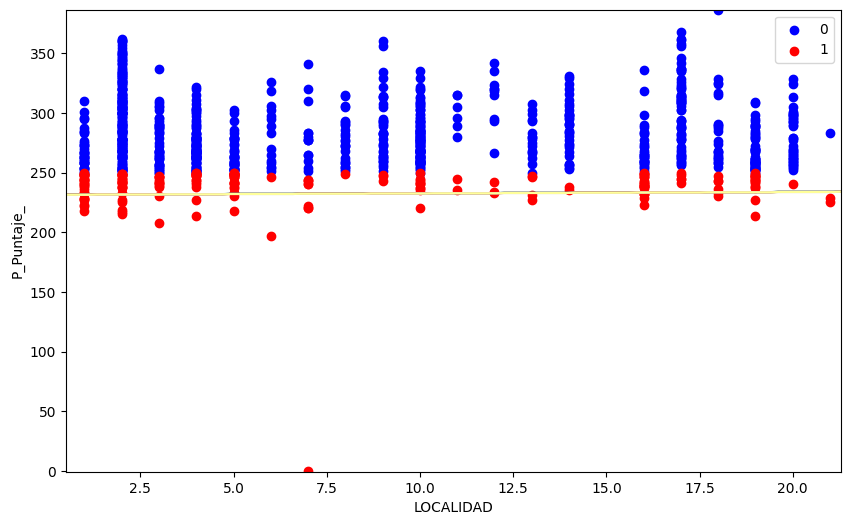

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
X = COLEGIOS[[X1, X2]]
y = COLEGIOS[Y]
# Entrena el modelo con todos los datos
model = LogisticRegression(solver='liblinear')
model.fit(X, y)
# Crea una malla para evaluar el modelo
x_min, x_max = X[X1].min() - 0.5, X[X1].max() + 0.5
y_min, y_max = X[X2].min() - 0.5, X[X2].max() + 0.5
h = (x_max - x_min)/100
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Predice en todos los puntos de la malla
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Crea el gráfico de dispersión de los datos
plt.figure(figsize=(10, 6))
plt.scatter(X[y == 0][X1], X[y == 0][X2], color='blue', label='0')
plt.scatter(X[y == 1][X1], X[y == 1][X2], color='red', label='1')
# Dibuja la frontera de decisión
plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
# Etiquetas y leyenda
plt.xlabel(X1)
plt.ylabel(X2)
plt.legend()
plt.show()

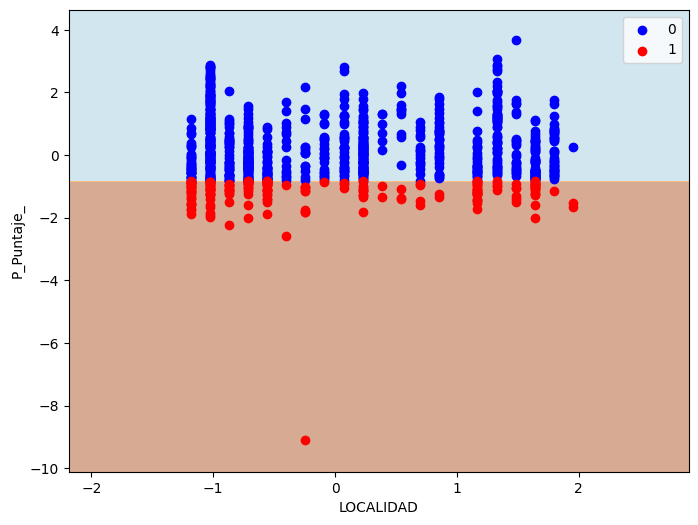

In [ ]:
# Crea el escalador
scaler = StandardScaler()
# Ajusta el escalador a los datos y transforma tanto el entrenamiento como los datos de prueba
X_scaled = scaler.fit_transform(X)
# Divide tus datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)
# Crea una instancia de LogisticRegression y ajústala a tus datos de entrenamiento
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
# Ahora puedes predecir los valores para tus datos de prueba
y_pred = model.predict(X_test)
# Crea una malla para evaluar el modelo
x_min, x_max = X_scaled[:, 0].min()-1, X_scaled[:, 0].max() + 1
y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
h = (x_max - x_min)/100
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Predice en todos los puntos de la malla
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Crea el gráfico de dispersión de los datos
plt.figure(figsize=(8, 6))
# Dibuja la frontera de decisión con colores de fondo
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)
plt.scatter(X_scaled[y == 0, 0], X_scaled[y == 0, 1], color='blue', label='0')
plt.scatter(X_scaled[y == 1, 0], X_scaled[y == 1, 1], color='red', label='1')
# Etiquetas y leyenda
plt.xlabel(X1)
plt.ylabel(X2)
plt.legend()
plt.show()